# 1  Objectives:

Predict the rating that a user would give to a movie that he has not yet rated.
Minimize the difference between predicted and actual rating (RMSE and MAPE).


In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from surprise import Reader,Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import  GridSearchCV

import pandas as  pd
import os

from scipy import sparse
from scipy.sparse import csr_matrix

# 2 Reading and Storing Data

In [2]:
if not os.path.isfile("./Data/NetflixRatings.csv"):
    startTime = datetime.now()
    data = open("./Data/NetflixRatings.csv", mode='w')
    files = ['./Data/combined_data_2.txt', './Data/combined_data_4.txt'] 
# This Line will create a file NetflxRatings.csv in write mode and add the above to files into this CSV file

    for file in files:
        print("Reading  from file : "+str(file)+ "......")
        with open(file) as f:
            for line in f:
                line = line.strip()  #Line.strip() function will clear all the spaces from the trailing and leading positions of the string
                if line.endswith(":"):
                    movieId = line.replace(":","")
                    
                else:
                    row = []
                    row = [x for x in line.split(",")]
                    row.insert(0,movieId)
                    data.write(",".join(row))
                    data.write("\n")
        print("reading of file:" +str(file)+ "is completed")
    data.close()
    print("Total time taken for execution of this code" +str(datetime.now() - startTime))
        
                    
print(datetime.now())
                    
                    
                    

2019-11-08 17:36:01.050458


In [ ]:
start = datetime.now()

print("Creating the dataframe from the data.csvfile....")
df = pd.read_csv('./Data/NetflixRatings.csv', sep=',' , names= ['movie','user', 'rating', 'date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

# We are arranging the ratings as per date and time
print('Sorting the  dataframe by date')
df.sort_values(by='date', inplace= True)
print('Done...')


print(datetime.now())

print(datetime.now() -start)



Creating the dataframe from the data.csvfile....


In [ ]:
df.head()

In [ ]:
df.describe()['rating']

In [ ]:
# Checking for NAN values and deleting the rows containing them
print('No of NAN Values in our datframe:', sum(df.isnull().any()))

# Removing the Duplicates


In [ ]:
dup_bool = df.duplicated(['movie','user', 'rating'])
dups = sum(dup_bool) # considering all columns including  timestamp
print('There are {} duplicate items in the dataframe'.format(dups))


#  Basic Statistics(#Ratings, #Users, and #Movies)

In [ ]:
print("Total Data")
print("-"*50)
print("\n Total number of ratings:",df.shape[0])
print("total number of users : ", len(np.unique(df.user)))
print("total number of movies : ", len(np.unique(df.movie)))


# 3 Splitting Data into Train and Test (Ratio 80:20)


In [4]:
# Splitting the Train and test and storing the data into train and test CSVs
if not os.path.isfile("./Data/train.csv"):
    df.iloc[:int(df.shape[0]*0.80)].to_csv("./Data/train.csv", index=False)

if  not os.path.isfile("./Data/test.csv"):
    df.iloc[int(df.shape[0]*0.80):].to_csv("./Data/test.csv",index=False)
    
train_df = pd.read_csv("./Data/train.csv", parse_dates = ['date'])
test_df = pd.read_csv("./Data/test.csv")

print(datetime.now())

2019-06-28 16:02:37.463242


# Basic Statistics in Train Set



In [5]:
print("training Data")
print("-"*50)
print("\nTotal number of ratings :", train_df.shape[0] )
print("Total number of Users : ", len(np.unique(train_df.user)))
print("Total number of movies: ", len(np.unique(train_df.movie)))

print(datetime.now())

training Data
--------------------------------------------------

Total number of ratings : 43060091
Total number of Users :  401901
Total number of movies:  8931


# Basic Statistics in Test Set

In [11]:
start = datetime.now()
print("Test Data")
print("-"*50)
print("\nTotal number of ratings :", test_df.shape[0] )
print("Total number of Users : ", len(np.unique(test_df.user)))
print("Total number of movies: ", len(np.unique(test_df.movie)))

print(datetime.now() -start)

Test Data
--------------------------------------------------

Total number of ratings : 10765023
Total number of Users :  327355
Total number of movies:  9107
0:00:02.946124


# Exploratory data analysis on Train Data


In [12]:
# Method to make y axis more readable
def human(num,units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + "k"
    elif units == 'm':
        return str(num/10**6) + "m"
    elif units == 'b':
        return str(num/10**9) + "b"
    
    

# Distribution of Ratings


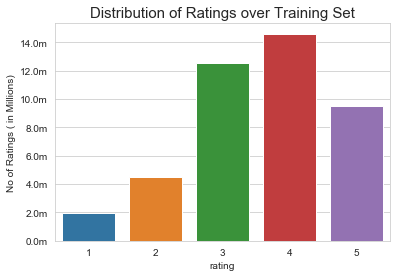

In [13]:
fig, ax = plt.subplots()
plt.title('Distribution of Ratings over Training Set', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item,'M') for item in ax.get_yticks()])
ax.set_ylabel('No of Ratings ( in Millions)')
plt.show()


# Distribution of ratings on Test Set

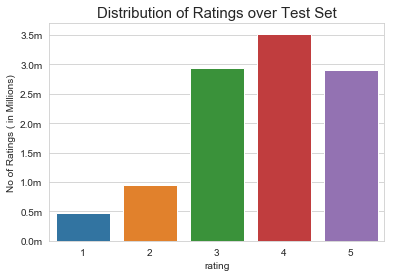

In [14]:
fig, ax = plt.subplots()
plt.title('Distribution of Ratings over Test Set', fontsize=15)
sns.countplot(test_df.rating)
ax.set_yticklabels([human(item,'M') for item in ax.get_yticks()])
ax.set_ylabel('No of Ratings ( in Millions)')
plt.show()

# 4 Add new Column (Week Day) to the Data set for analysis

In [5]:
# it is used to skip the warning message " Settingwithcopywriting"
pd.options.mode.chained_assignment = None # default = 'warn'
train_df['day of Week'] = train_df.date.dt.weekday_name
train_df.tail()
print("done...")

done...


# Number of Ratings per month

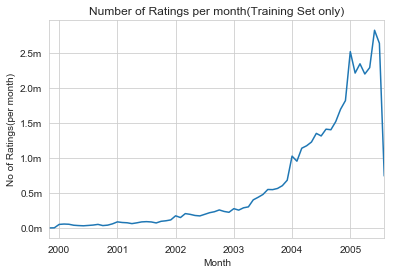

In [16]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('Number of Ratings per month(Training Set only)')
plt.xlabel('Month')
plt.ylabel('No of Ratings(per month)')
ax.set_yticklabels([human(item,'M') for item in ax.get_yticks()])
plt.show()


# Analysis on the Ratings given by users


In [17]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)
no_of_rated_movies_per_user.head()


user
305344     8779
2439493    8126
387418     7884
1639792    4983
1461435    4846
Name: rating, dtype: int64

In [18]:
no_of_rated_movies_per_user.tail()

user
1406680    1
1227925    1
1228032    1
2191231    1
1545908    1
Name: rating, dtype: int64

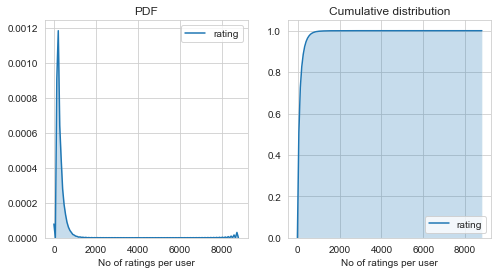

In [19]:
fig = plt.figure(figsize=plt.figaspect(0.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel("No of ratings per user")
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user,shade=True, cumulative=True, ax = ax2)
plt.xlabel("No of ratings per user")
plt.title("Cumulative distribution")


plt.show()


In [20]:
no_of_rated_movies_per_user.describe()

count    401901.00000
mean        107.14104
std         155.05350
min           1.00000
25%          19.00000
50%          48.00000
75%         133.00000
max        8779.00000
Name: rating, dtype: float64

# Quantiles

In [21]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')


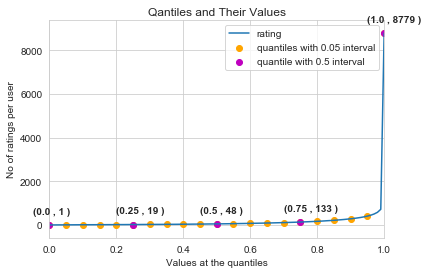

In [27]:
plt.title("Qantiles and Their Values")
quantiles.plot()
# Quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c= 'orange', label="quantiles with 0.05 interval")
# quantiles with 0.5 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label="quantile with 0.5 interval")
plt.ylabel('No of ratings per user')
plt.xlabel('Values at the quantiles')
plt.legend(loc='best')


# annotations at 25th, 50th, 75th, 100th Percentile values
for x,y in zip(quantiles.index[::25],quantiles[::25]):
    plt.annotate(s="({} , {} )".format(x,y), xy=(x,y), xytext=(x-0.05, y+500) ,fontweight='bold')
    
plt.show()

In [28]:
quantiles[::5]

0.00       1
0.05       4
0.10       8
0.15      12
0.20      15
0.25      19
0.30      23
0.35      27
0.40      33
0.45      40
0.50      48
0.55      59
0.60      72
0.65      88
0.70     108
0.75     133
0.80     166
0.85     213
0.90     281
0.95     404
1.00    8779
Name: rating, dtype: int64

# How many ratings at the last 5% of all ratings?


In [29]:
print('\n No of ratings at the last 5 percentile: {} \n'.format(sum(no_of_rated_movies_per_user>=404)))



 No of ratings at the last 5 percentile: 20181 



# Analysis of ratings of a movie given by a user

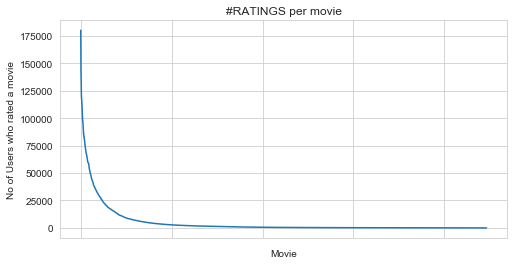

In [30]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig= plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()

plt.plot(no_of_ratings_per_movie.values)
plt.title('#RATINGS per movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

No of Ratings for each day of the week

In [ ]:
fig, ax = plt.subplots()
sns.catplot(x='day of Week',kind='count', data=train_df, ax=ax)
plt.title(" no of ratings on each day...")
plt.ylabel('total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item,'M') for item in ax.get_yticks()])
plt.show()

In [ ]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day of Week', data=train_df)
plt.show()
print(datetime.now() -start)


In [7]:
avg_week_df = train_df.groupby(by=['day of Week'])['rating'].mean()
print('average ratings:')
print('-'*50)
print(avg_week_df)
print('\n')


average ratings:
--------------------------------------------------
day of Week
Friday       3.589555
Monday       3.577235
Saturday     3.595120
Sunday       3.596637
Thursday     3.583570
Tuesday      3.574852
Wednesday    3.585002
Name: rating, dtype: float64




# 5 Creating Sparse Matrix from the Data frame


In [6]:
start = datetime.now()
if os.path.isfile("train_sparse_matrix.npz"):
    print("it is present in your present working directory")
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("Done...")
else:
    print(" we are creating sparse matrix from the train data frame")
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values, train_df.movie.values)),)
    print("Done It\'s shape is : (user,movie): ", train_sparse_matrix.shape)
    print("saving it to disk for further usage..")
    
    sparse.save_npz("train_sparse_matrix.npz",train_sparse_matrix)
    print("Save Done...\n")

print(datetime.now() -start)


it is present in your present working directory
Done...
0:00:03.684058


In [16]:
from numpy import load

data = load('train_sparse_matrix.npz')
lst = data.files

for item in lst:
    print(item)
    print(data[item])

indices
[ 4506  4577  4590 ... 17622 17627 17692]
indptr
[       0        0        0 ... 43059959 43059959 43060091]
format
b'csr'
shape
[2649430   17771]
data
[3 3 3 ... 4 3 2]


# Sparsity of the Train Matrix

In [17]:
us,mv =  train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("sparsity of the train matrix : {} %".format(   (1 -(elem/(us*mv)) ) *100  ))

sparsity of the train matrix : 99.90854433187319 %


# 6 Creating Sparx matrix from test Data frame

In [7]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your present working directory, getting it from the disk")
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    
    print("Done....\n")
    
    
else:
    print("we are creating a test Sprse metrix now from the dataframe..")
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values,(test_df.user.values,test_df.movie.values)))
    print("Done...\n")
    print("It\'s shape is : (User,movie): ", test_sparse_matrix.shape)
    print("Saving it into the disk for further usage")
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print("Done...")

print(datetime.now() - start)


It is present in your present working directory, getting it from the disk
Done....

0:00:00.765139


In [19]:
from numpy import load

data = load('test_sparse_matrix.npz')
lst = data.files

for item in lst:
    print(item)
    print(data[item])

indices
[ 4522  4682  4697 ... 14644 15107 15788]
indptr
[       0        0        0 ... 10765009 10765009 10765023]
format
b'csr'
shape
[2649430   17771]
data
[4 3 4 ... 3 5 5]


#The sparsity of the test data matrix

In [20]:
us,mv =  test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("sparsity of the train matrix : {} %".format(   (1 -(elem/(us*mv)) ) *100  ))

sparsity of the train matrix : 99.97713608243731 %


# 7 Finding Global average of all Movie ratings, Average rating per user, Average rating per movie

In [8]:
# get the user averages in a dictionary ( Key: userid/movie Id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    # average ratiing of user per axis
    ax = 1 if of_users else 0 # 1 - user axes, 0- Movie Axis
    #.A1 is to convert Column Matrix into 1-D numpy array
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    
    # Boolean Matrix of ratings(whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    
    # No of ratings for eac user or movie
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max User and max movie Ids is sparse matrix
    u,m = sparse_matrix.shape
    
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i]
                                  for i in range(u if of_users else m)
                                      if no_of_ratings[i] !=0 }
    
    # return that dictionary of average ratings
    return average_ratings


#Findng Global average of all movie ratings

In [9]:
train_averages = dict()
# get the global average of the ratings in our train set
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['Global'] = train_global_average
train_averages

{'Global': 3.5844935859517806}

#Finding average rating per user

In [10]:
train_averages['User'] = get_average_ratings(train_sparse_matrix,of_users=True)
print('\n Average rating of the user 305344:', train_averages['User'][305344])


 Average rating of the user 305344: 1.9400842920605992


In [11]:
train_averages['movie'] = get_average_ratings(train_sparse_matrix,of_users=False)
print('Average rating of the movie 4534:', train_averages['movie'][4534])

Average rating of the movie 4534: 3.5065963060686016


# PDF and CDF of Average Ratings of Users and Movies ( In train Data)

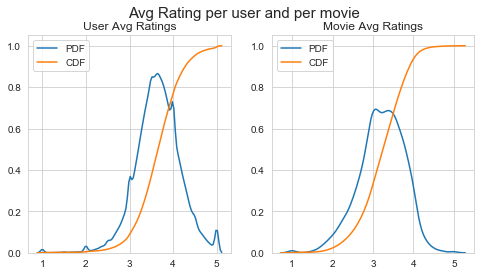

0:01:37.012043


In [12]:
start = datetime.now()
# Draw PDFs of average ratings  per users and Movies
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize= plt.figaspect(.5))
fig.suptitle("Avg Rating per user and per movie", fontsize=15)

ax1.set_title('User Avg Ratings')
# get the average user ratings from the averages dictionary
user_averages = [ rat for rat in train_averages['User'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, label='PDF')
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True),label='CDF')




ax2.set_title('Movie Avg Ratings')
# get the average user ratings from the averages dictionary
movie_averages = [cat for cat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False,label='PDF')
sns.distplot(movie_averages, ax=ax2, hist=False, kde_kws=dict(cumulative=True),label='CDF')


plt.show()
print(datetime.now() -start)

# Cold Start Problem 

cold Start Problem with Users

In [13]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['User'])
new_users = total_users - users_train

print("total number of USer: ", total_users)
print("number of train Users : ", users_train)
print("new User : {} ({} %) ".format(new_users, np.round((new_users/total_users)*100,2)) )

total number of USer:  478723
number of train Users :  401901
new User : 76822 (16.05 %) 


cold start problem with Movies

In [14]:
total_movies = len(np.unique(df.movie))
movie_train = len(train_averages['movie'])
new_movie = total_movies - movie_train

print("total number of USer: ", total_movies)
print("number of train Users : ", movie_train)
print("new User : {} ({} %) ".format(new_movie, np.round((new_movie/total_movies)*100,2)) )

total number of USer:  9114
number of train Users :  8931
new User : 183 (2.01 %) 


# Computing similarity Matrices

computing movie-movie similarity matrix

In [15]:
start = datetime.now()
if not os.path.isfile('movie_movie_sim_sparse.npz'):
    print("It seems you dont have that file, computing movie-movie similarity")
    start = datetime.now()
    m_m_Similarity_sparse = cosine_similarity(X= train_sparse_matrix.T, dense_output=False)
    print('Done...')
    print("Saving it to the disk withut the need to re-computing it again..")
    print("done")
    
else:
    print("It is there, we will get it")
    m_m_Similarity_sparse = sparse.load_npz("m_m_Similarity_sparse.npz")
    print("done...")
    
    
print(datetime.now() -start)



It seems you dont have that file, computing movie-movie similarity
Done...
Saving it to the disk withut the need to re-computing it again..
done
0:01:43.267694


In [17]:
m_m_Similarity_sparse.shape


(17771, 17771)

In [23]:


movie_ids = np.unique(m_m_Similarity_sparse.nonzero()[1])

In [31]:
start= datetime.now()
similar_movies =dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_Similarity_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)
similar_movies[8357]


0:00:16.888785


TypeError: unhashable type: 'slice'

Finding Most similar movies details into Soe datframe 
Movie details are in the netflix/movie_titles.csv


In [32]:
movie_titles = pd.read_csv("./Data/movie_titles.csv", sep=',', header =None, 
                           names=['movie_id','year_of_release','title'],verbose=True,
                          index_col = 'movie_id', encoding="ISO-8859-1")
movie_titles.head()

Tokenization took: 2.77 ms
Type conversion took: 8.00 ms
Parser memory cleanup took: 0.00 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


Similar Movies for 'The Bridges of Madison County'

In [35]:
mv_id = 8357
print("\n Movie ---> ", movie_titles.loc[mv_id].values[1])
print("\nIt has {} ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))
print("\n We have {} movies which are similar to this and we will get only top most..".format(m_m_Similarity_sparse[:,mv_id].getnnz()) )


 Movie --->  The Bridges of Madison County

It has 14638 ratings from users.

 We have 8898 movies which are similar to this and we will get only top most..


In [36]:
similarities = m_m_Similarity_sparse[mv_id].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]
sim_indices  = similarities.argsort()[::-1][1:]
# It will sort and reverse the array and ignore its similarity (ie.,1)
# and return its indices(movie_ids)

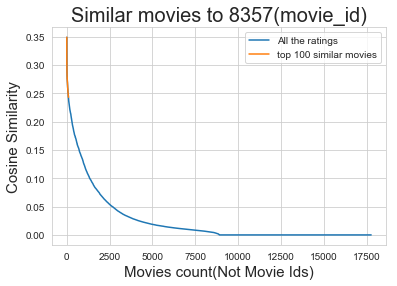

In [38]:
plt.plot(similarities[sim_indices],label='All the ratings')
plt.plot(similarities[sim_indices[:100]],label='top 100 similar movies')
plt.title("Similar movies to {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies count(Not Movie Ids)",fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

top 10 similar movies

In [39]:
movie_titles.loc[sim_indices[:10]]

,year_of_release,title
movie_id,,
9110,1998.0,The Horse Whisperer
5137,1985.0,Out of Africa
13392,1983.0,Terms of Endearment
4545,1990.0,Dances With Wolves: Special Edition
17709,1992.0,A River Runs Through It
7364,1989.0,Driving Miss Daisy
15058,1999.0,Notting Hill
6615,1994.0,Legends of the Fall
14667,1989.0,Field of Dreams
